# Analysis of Datetime Bugs

In [ ]:
# Install dependencies if missing
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install wordcloud

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors

SAVE_PATH = "./visualizations/"

# Read the data from the TSV file
df = pd.read_csv('./data/bugs_analysis_base.tsv', sep='\t')
print("Total number of datapoints: ", len(df))
df.head()

Total number of datapoints:  151


,Owner,Project,Title,Link,Fix Link,Stars,TF-IDFs,Size,Datetime,Arrow,...,Erroneous Computation 1,Erroneous Computation 2,Erroneous Computation 3,Obscurity,Impact,# LOC,Logic Needed,Bug Pattern 1,Bug Pattern 2,Bug Pattern 3
0,python-poetry,tomlkit,datetime.utcnow and datetime.utcfromtimestamp ...,https://github.com/python-poetry/tomlkit/issue...,https://github.com/python-poetry/tomlkit/commi...,643.0,1.312623,1001.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
1,frictionlessdata,frictionless-py,SpssParser ignores timezones,https://github.com/frictionlessdata/frictionle...,https://github.com/frictionlessdata/frictionle...,683.0,1.270077,1279.0,1.0,0.0,...,Datetime (Construction),Parsing/Formatting,NaN,Low,Medium,Medium,High,Dropping Time Zone Information,NaN,NaN
2,sdispater,pendulum,Deepcopy of Month-based Duration produces a di...,https://github.com/sdispater/pendulum/issues/714,https://github.com/sdispater/pendulum/commit/9...,6109.0,1.191295,1014.0,1.0,0.0,...,Delta API,NaN,NaN,Medium,Medium,Medium,Low,Unintuitive Arithmetic,NaN,NaN
3,googleapis,python-storage,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-storage/i...,https://github.com/googleapis/python-storage/c...,420.0,1.176351,10349.0,1.0,0.0,...,Datetime (Arithmetic),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN
4,googleapis,python-logging,`DeprecationWarning` warning in build log for ...,https://github.com/googleapis/python-logging/i...,https://github.com/googleapis/python-logging/p...,119.0,1.167279,2673.0,1.0,0.0,...,Datetime (Construction),NaN,NaN,Low,Low,Low,Low,Outdated/Deprecated APIs,NaN,NaN


df.columns
"""
Index(
       ['Owner', 'Project', 'Title', 'Stars', 'TF-IDFs', 'Size', 'Datetime',
       'Arrow', 'Pendulum', 'Description', 'Category 1', 'Category 2',
       'Erroneous Computation 1', 'Erroneous Computation 2',
       'Bug Pattern 3', 'Obscurity', 'Impact/Severity', '# LOC',
       'Logic Needed', 'Comments', 'BPST1', 'BPST2', 'BPST3'],
dtype='object')
"""

## What are the highlevel terms used to describe date and time bugs?

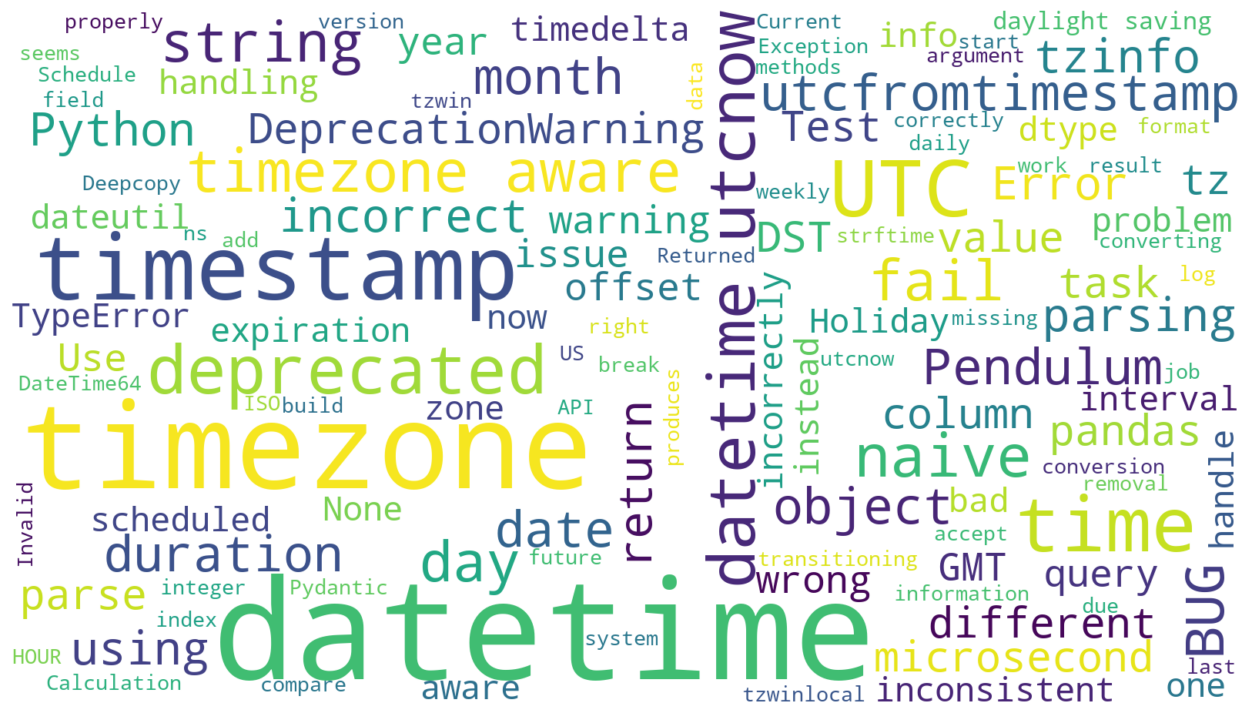

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 1. Combine all text from the column into a single string
text = ' '.join(df['Title'].astype(str))

# 2. Create a WordCloud object
wordcloud = WordCloud(
    width=1600, 
    height=900, 
    max_font_size=180,
    max_words=120,
    background_color="white",
    colormap='viridis',
    # mask=datetime_mask,
    contour_width=1,
    ).generate(text)

# 3. Display the generated image
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(SAVE_PATH+'wordcloud.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Stats about bug obscurity/impact and fix complexity/#loc

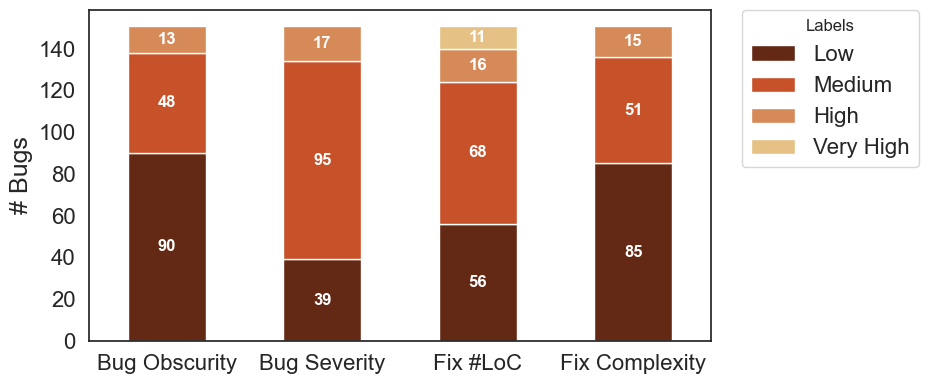

In [5]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

# select only specific columns
df_new = df[['# LOC', 'Logic Needed', 'Obscurity', 'Impact']]

# Count occurrences for each category in each column
loc_counts = df_new['# LOC'].value_counts()
logic_counts = df_new['Logic Needed'].value_counts()
obscurity_counts = df_new['Obscurity'].value_counts()
impact_counts = df_new['Impact'].value_counts()

# Ensure all categories are in the same order
categories = ['Low', 'Medium', 'High', 'Very High']
loc_counts = loc_counts.reindex(categories, fill_value=0)
logic_counts = logic_counts.reindex(categories, fill_value=0)
obscurity_counts = obscurity_counts.reindex(categories, fill_value=0)
impact_counts = impact_counts.reindex(categories, fill_value=0)

# Compose the data for a stacked bar chart
stacked_data = pd.DataFrame({
    'Bug Obscurity': obscurity_counts,
    'Bug Severity': impact_counts,
    'Fix #LoC': loc_counts,
    'Fix Complexity': logic_counts,
}, index=categories)

# Transpose the data for plotting
stacked_data = stacked_data.T

# Plotting
ax = stacked_data.plot(kind='bar', stacked=True, color=colors[:4], figsize=(12, 4), width=0.5)

# Iterate over each column in the DataFrame and display the value on the bars
for i, bar in enumerate(ax.containers):
    # Use ax.bar_label() in case of Matplotlib >= 3.4
    ax.bar_label(bar, label_type='center', fontsize=12, color='white', fontweight='bold', labels=['' if v==0 else int(v) for v in bar.datavalues])
    # ax.bar_label(bar, label_type='center', fontsize=12, color='white', labels=['' if v==0 else int(v) for v in bar.datavalues])

# Place legend outside the plot
ax.legend(title='Labels', fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Set labels and layout
plt.ylabel('# Bugs', fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

# Save and show the plot
plt.savefig(SAVE_PATH + 'stacked_bar_chart.pdf', transparent=True, bbox_inches='tight')
plt.show()

## What are the most common causes of bugs?
### Plot the Broad Categories.

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:20: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


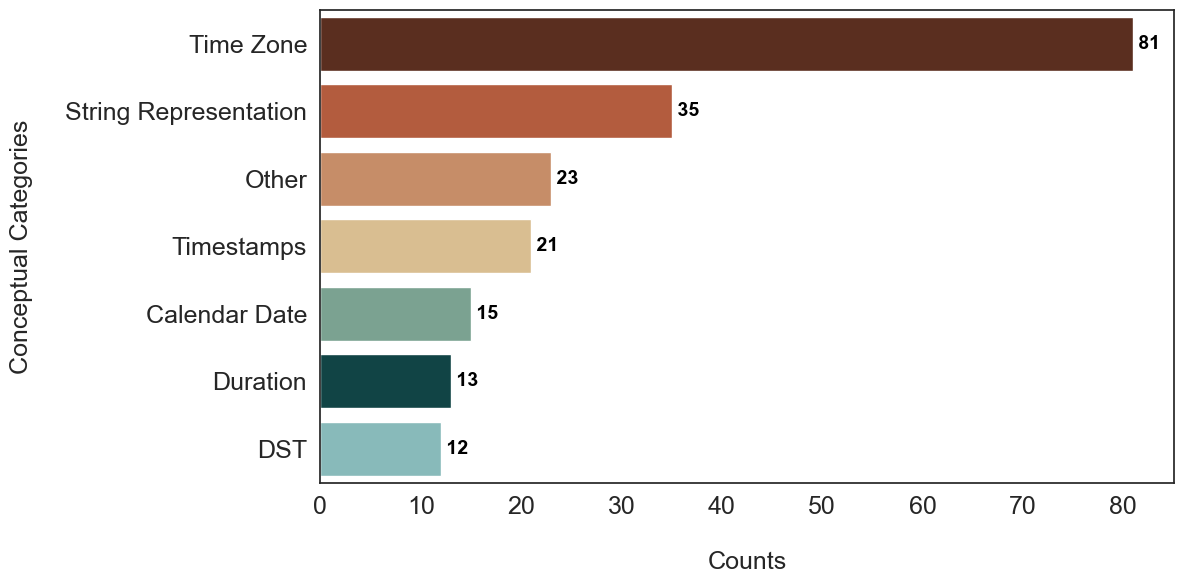

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:57: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


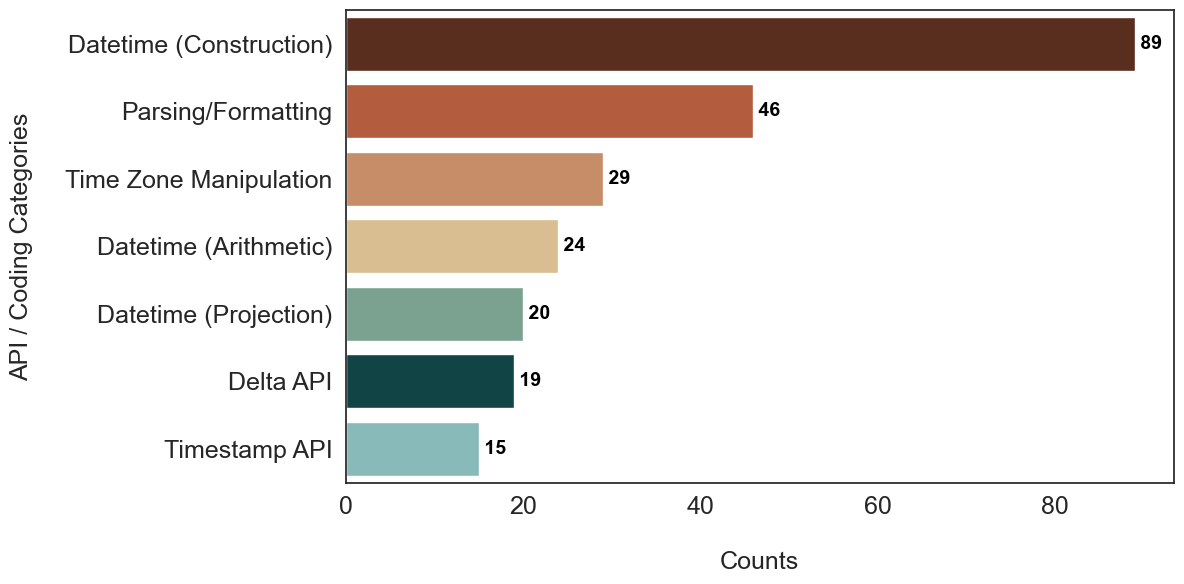

/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)
/var/folders/gg/nddyhpc10f5f1y17l64pb9_r0000gq/T/ipykernel_20245/1976900518.py:95: UserWarning: 
The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)


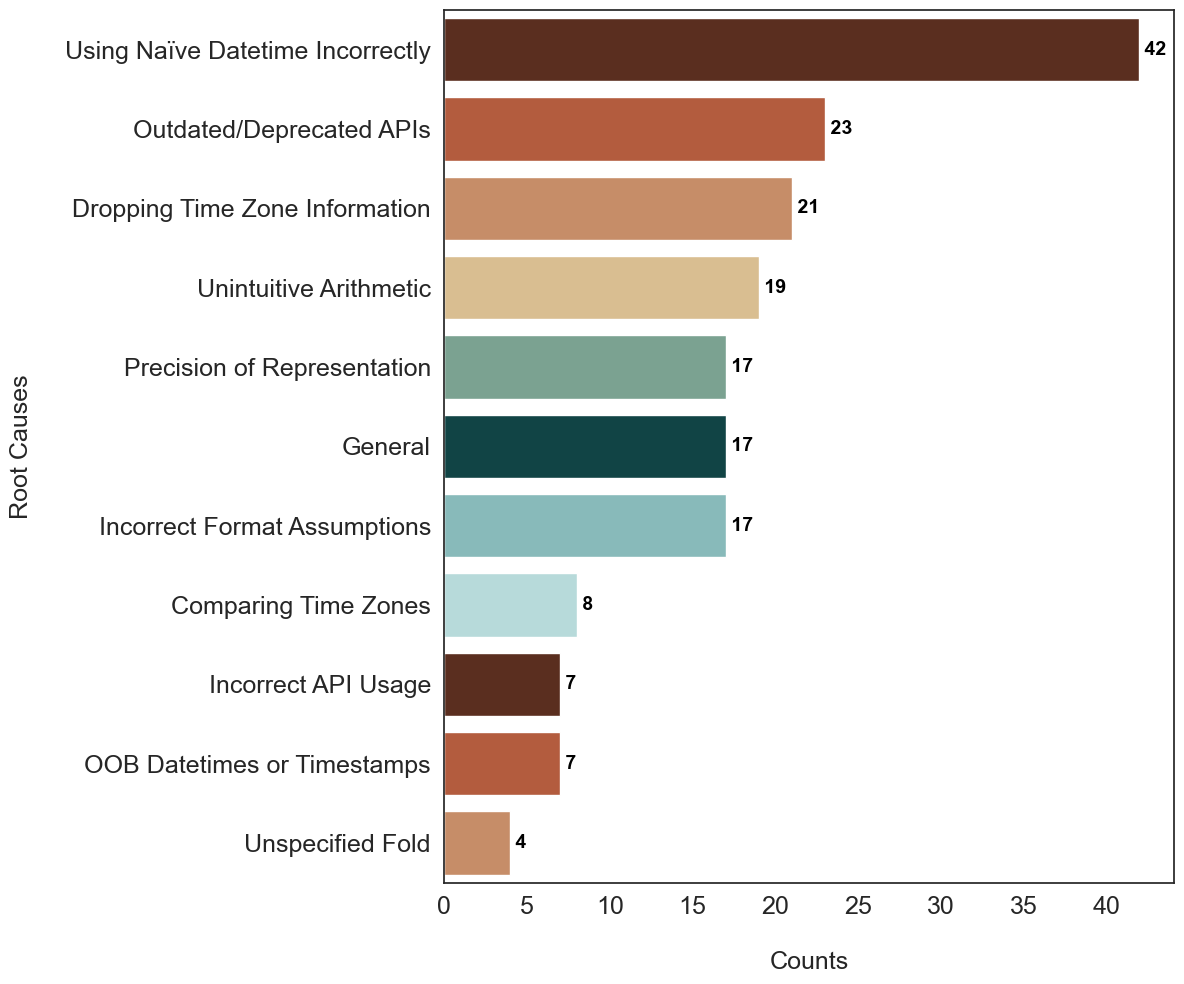

In [3]:
# Define the colors for the bar chart
colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
sns.set_theme(style='white')

#######################################################################################

# Conceptual Categories
# Merge both categories into one Series
combined_categories = pd.concat([df['Category 1'], df['Category 2']])

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Conceptual Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'conceptual_categories.pdf', bbox_inches='tight')
plt.show()

#######################################################################################


# What are the most common Erroneous Computations?
timezone_df = df.copy()

# Merge all Erroneous Computation columns into one Series
combined_categories = pd.concat([timezone_df['Erroneous Computation 1'], 
                                 timezone_df['Erroneous Computation 2'], 
                                 timezone_df['Erroneous Computation 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add annotations
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha="left", va="center", fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('API / Coding Categories\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Use this to control y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Use this to control x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'api_categories.pdf', bbox_inches='tight')
plt.show()


#######################################################################################


# What are the most common Bugs?
timezone_df = df.copy()

# Merge Bug Patterns into one Series
combined_categories = pd.concat([timezone_df['Bug Pattern 1'], 
                                 timezone_df['Bug Pattern 2'], 
                                 timezone_df['Bug Pattern 3']])
combined_categories = combined_categories.dropna()

# Count occurrences of each category
category_counts = combined_categories.value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort DataFrame by Count
category_counts = category_counts.sort_values("Count", ascending=False)

# Plotting
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Count', y='Category', data=category_counts, palette=colors)

# Add numerical annotations on each bar
for index, row in category_counts.iterrows():
    ax.text(row.Count, index, f' {row.Count} ', color='black', ha='left', va='center', fontsize=14, fontweight='bold')

# Set labels and titles
ax.set_xlabel('\nCounts', fontsize=18)
ax.set_ylabel('Root Causes\n', fontsize=18)
ax.tick_params(axis='y', labelsize=18)  # Manage y-tick label sizes
ax.tick_params(axis='x', labelsize=18)  # Manage x-tick label sizes

plt.tight_layout()
plt.savefig(SAVE_PATH + 'root_causes.pdf', bbox_inches='tight')
plt.show()

     Bug Obscurity  Bug Severity  Fix #LoC  Fix Complexity
0                1             1         1               1
1                1             2         2               3
2                2             2         2               1
3                1             1         1               1
4                1             1         1               1
..             ...           ...       ...             ...
146              1             2         1               1
147              2             2         3               2
148              1             1         2               1
149              2             1         2               2
150              3             1         1               1

[151 rows x 4 columns]
                Bug Obscurity  Bug Severity  Fix #LoC  Fix Complexity
Bug Obscurity        1.000000     -0.107202  0.115292        0.218010
Bug Severity        -0.107202      1.000000  0.082258        0.180872
Fix #LoC             0.115292      0.082258  1.000000     

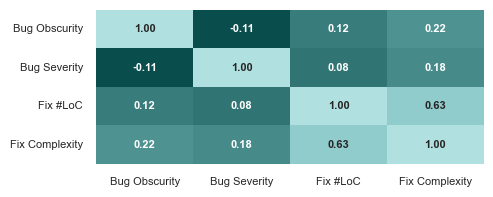

In [4]:
# Convert low, medium, high to 1, 2, 3 for 'Obscurity', 'Impact', '# LOC', and 'Logic Needed'
df_temp = df.copy()
df_temp['Impact'] = df['Impact'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['Obscurity'] = df['Obscurity'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_temp['# LOC'] = df['# LOC'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
df_temp['Logic Needed'] = df['Logic Needed'].map({'Low': 1, 'Medium': 2, 'High': 3})

df_temp = df_temp[['Obscurity', 'Impact', '# LOC', 'Logic Needed']]
df_temp = df_temp.dropna()

# rename the columns
df_temp.columns = ['Bug Obscurity', 'Bug Severity', 'Fix #LoC', 'Fix Complexity']

print(df_temp)
print(df_temp.corr())

colors = ["#642915", "#c7522a", "#d68a58", "#e5c185", "#74a892", "#094d4d", "#80c2c2", "#b1e0e0"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("", colors[5:])

plt.figure(figsize=(5, 2))  # Adjust width and height as needed

# Create the heatmap
heatmap = sns.heatmap(df_temp.corr(),
                       annot=True,
                       annot_kws={"size": 8, "weight": "bold"},
                       cmap=custom_cmap,
                       fmt=".2f",
                       cbar=False)  # Optional: adjust color bar size

# Set the tick labels size and rotation
plt.xticks(fontsize=8, rotation=0)  # X-axis tick labels
plt.yticks(fontsize=8, rotation=0)   # Y-axis tick labels

# Save and show the plot
plt.savefig(SAVE_PATH+'correlation_plot.pdf', transparent=True, bbox_inches='tight')
plt.show()